In [ ]:
from os import putenv
putenv("TF_XLA_FLAGS", "--tf_xla_enable_xla_devices=false")

In [ ]:
import pandas as pd
from shutil import move
import os
from tqdm import tqdm
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from pathlib import Path
import glob
from annoy import AnnoyIndex
import pickle
from IPython.display import Image as dispImage
import tf_keras
tqdm.pandas()

2025-02-08 15:12:24.187933: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv('recomendacao/styles2.csv', sep=',',usecols=['id','masterCategory']).reset_index()
df['id'] = df['id'].astype('str')

In [ ]:
all_images = os.listdir('recomendacao/images/')
co = 0
os.mkdir('recomendacao/categories')
for image in tqdm(all_images):
    category = df[df['id'] == image.split('.')[0]]['masterCategory']
    category = str(list(category)[0])
    if not os.path.exists(os.path.join('recomendacao/categories', category)):
        os.mkdir(os.path.join('recomendacao/categories', category))
    path_from = os.path.join('recomendacao/images', image)
    path_to = os.path.join('recomendacao/categories', category, image)
    move(path_from, path_to)
    co += 1
print('Moved {} images.'.format(co))

100%|██████████| 44441/44441 [01:38<00:00, 449.72it/s]

Moved 44441 images.


In [4]:
df.head()

,index,id,masterCategory
0,0,15970,Apparel
1,1,39386,Apparel
2,2,59263,Accessories
3,3,21379,Apparel
4,4,53759,Apparel


## Modelo de extracao de features

In [5]:
MODULE_HANDLE = 'https://tfhub.dev/google/bit/m-r50x3/1'
IMAGE_SIZE = (224, 224)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))
BATCH_SIZE = 32 
N_FEATURES = 256

Using https://tfhub.dev/google/bit/m-r50x3/1 with input size (224, 224)


In [6]:
data_dir = 'recomendacao/categories'

In [7]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 8886 images belonging to 7 classes.
Found 35555 images belonging to 7 classes.


In [8]:
print("Building model with", MODULE_HANDLE)
model = tf_keras.Sequential([
    tf_keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=False),
    tf_keras.layers.Dropout(rate=0.2),
    tf_keras.layers.Dense(N_FEATURES,
                          kernel_regularizer=tf_keras.regularizers.l2(0.0001)),
    tf_keras.layers.Dropout(rate=0.2),
    tf_keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf_keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/bit/m-r50x3/1


2025-02-08 14:29:22.941270: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-08 14:29:26.131617: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-08 14:29:26.131704: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-08 14:29:26.132578: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-08 14:29:26.132705: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 6144)              211174080 
                                                                 
 dropout (Dropout)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 256)               1573120   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 212748999 (811.57 MB)
Trainable params: 1574919 (6.01 MB)
Non-trainable params: 211174080 (805.57 MB)
_________________________________________________________________


In [9]:
# Define optimiser and loss
lr = 0.003 * BATCH_SIZE / 512 
SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf_keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf_keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf_keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [10]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5


I0000 00:00:1739035862.908142   13735 service.cc:146] XLA service 0x71b14c129370 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739035862.908168   13735 service.cc:154]   StreamExecutor device (0): Radeon RX 7900 XTX, AMDGPU ISA version: gfx1100
I0000 00:00:1739035862.934212   13735 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1111/1111 [==============================] - 403s 305ms/step - loss: 0.2428 - accuracy: 0.9678 - val_loss: 0.1274 - val_accuracy: 0.9896
Epoch 2/5
1111/1111 [==============================] - 380s 338ms/step - loss: 0.1895 - accuracy: 0.9776 - val_loss: 0.1392 - val_accuracy: 0.9888
Epoch 3/5
1111/1111 [==============================] - 339s 305ms/step - loss: 0.1933 - accuracy: 0.9769 - val_loss: 0.1392 - val_accuracy: 0.9888
Epoch 4/5
1111/1111 [==============================] - 340s 306ms/step - loss: 0.1895 - accuracy: 0.9787 - val_loss: 0.1391 - val_accuracy: 0.9888
Epoch 5/5
1111/1111 [==============================] - 341s 307ms/step - loss: 0.1923 - accuracy: 0.9765 - val_loss: 0.1391 - val_accuracy: 0.9888


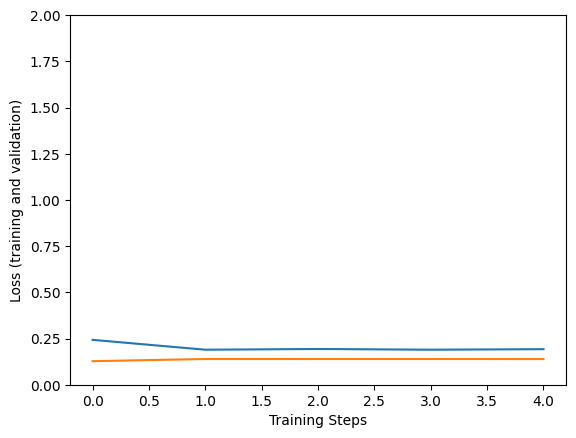

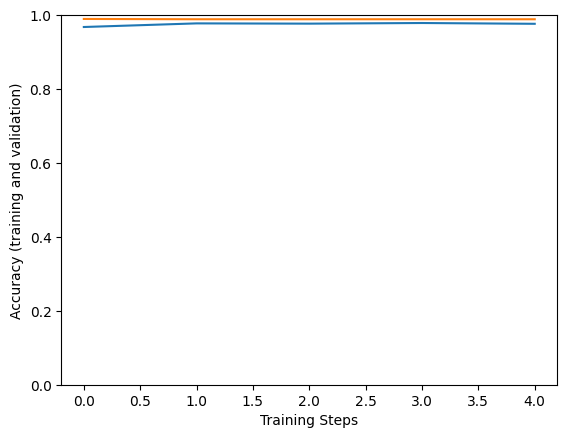

In [11]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [12]:
feature_extractor = tf_keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
feature_extractor.save('recomendacao/modelo/bit_feature_extractor', save_format='tf')

saved_model_path = 'recomendacao/modelo/bit_model'
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: recomendacao/modelo/bit_feature_extractor/assets


INFO:tensorflow:Assets written to: recomendacao/modelo/bit_feature_extractor/assets


INFO:tensorflow:Assets written to: recomendacao/modelo/bit_model/assets


INFO:tensorflow:Assets written to: recomendacao/modelo/bit_model/assets


## Vetorização

In [3]:
img_paths = []
for path in Path('recomendacao/categories').rglob('*.jpg'):
  img_paths.append(path)
np.random.shuffle(img_paths)

In [4]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

In [6]:
TRANSFER_LEARNING_FLAG = 1
if TRANSFER_LEARNING_FLAG:
  module = tf_keras.models.load_model('recomendacao/modelo/bit_feature_extractor')
else:
  module_handle = "https://tfhub.dev/google/bit/s-r50x3/ilsvrc2012_classification/1" 
  module = hub.load(module_handle)

2025-02-08 15:13:19.956676: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-08 15:13:23.119087: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-08 15:13:23.119195: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-08 15:13:23.120197: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-08 15:13:23.120321: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

In [7]:
imgvec_path = 'recomendacao/img_vetores/'
Path(imgvec_path).mkdir(parents=True, exist_ok=True)

In [8]:
for filename in tqdm(img_paths[:5000]):
    img = load_img(str(filename))
    features = module(img)
    feature_set = np.squeeze(features)
    outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
    out_path_file = os.path.join(imgvec_path, outfile_name)
    np.savetxt(out_path_file, feature_set, delimiter=',')

100%|██████████| 5000/5000 [04:31<00:00, 18.44it/s]


## Metadata e Indexação

In [9]:
test_img = 'recomendacao/categories/Accessories/1599.jpg'
dispImage(test_img)
root_path = 'recomendacao'

In [ ]:
styles = pd.read_csv('recomendacao/styles2.csv')
styles['id'] = styles['id'].astype('str')
styles.to_csv(root_path+'/styles2.csv', index=False)

In [12]:
def match_id(fname):
  return styles.index[styles.id==fname].values[0]

In [13]:
# Defining data structures as empty dict
file_index_to_file_name = {}
file_index_to_file_vector = {}
file_index_to_product_id = {}

# Configuring annoy parameters
dims = 256
n_nearest_neighbors = 20
trees = 10000

# Reads all file names which stores feature vectors 
allfiles = glob.glob('recomendacao/img_vetores/*.npz')

t = AnnoyIndex(dims, metric='angular')

In [14]:
for findex, fname in tqdm(enumerate(allfiles)):
  file_vector = np.loadtxt(fname)
  file_name = os.path.basename(fname).split('.')[0]
  file_index_to_file_name[findex] = file_name
  file_index_to_file_vector[findex] = file_vector
  try:
    file_index_to_product_id[findex] = match_id(file_name)
  except IndexError:
    pass 
  t.add_item(findex, file_vector)

5000it [00:11, 437.93it/s]


In [15]:
t.build(trees)
t.save('t.ann')

True

In [16]:
#hide
file_path = 'recomendacao'

In [17]:
t.save(file_path+'indexer.ann')
pickle.dump(file_index_to_file_name, open(file_path+"file_index_to_file_name.p", "wb"))
pickle.dump(file_index_to_file_vector, open(file_path+"file_index_to_file_vector.p", "wb"))
pickle.dump(file_index_to_product_id, open(file_path+"file_index_to_product_id.p", "wb"))

## Teste

In [18]:
from PIL import Image
import matplotlib.image as mpimg

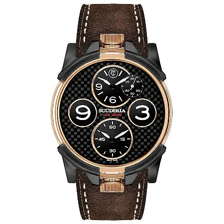

In [20]:
test_img = 'ImageTeste1.jpg'
topK = 4

test_vec = np.squeeze(module(load_img(test_img)))

basewidth = 224
img = Image.open(test_img)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize))
img

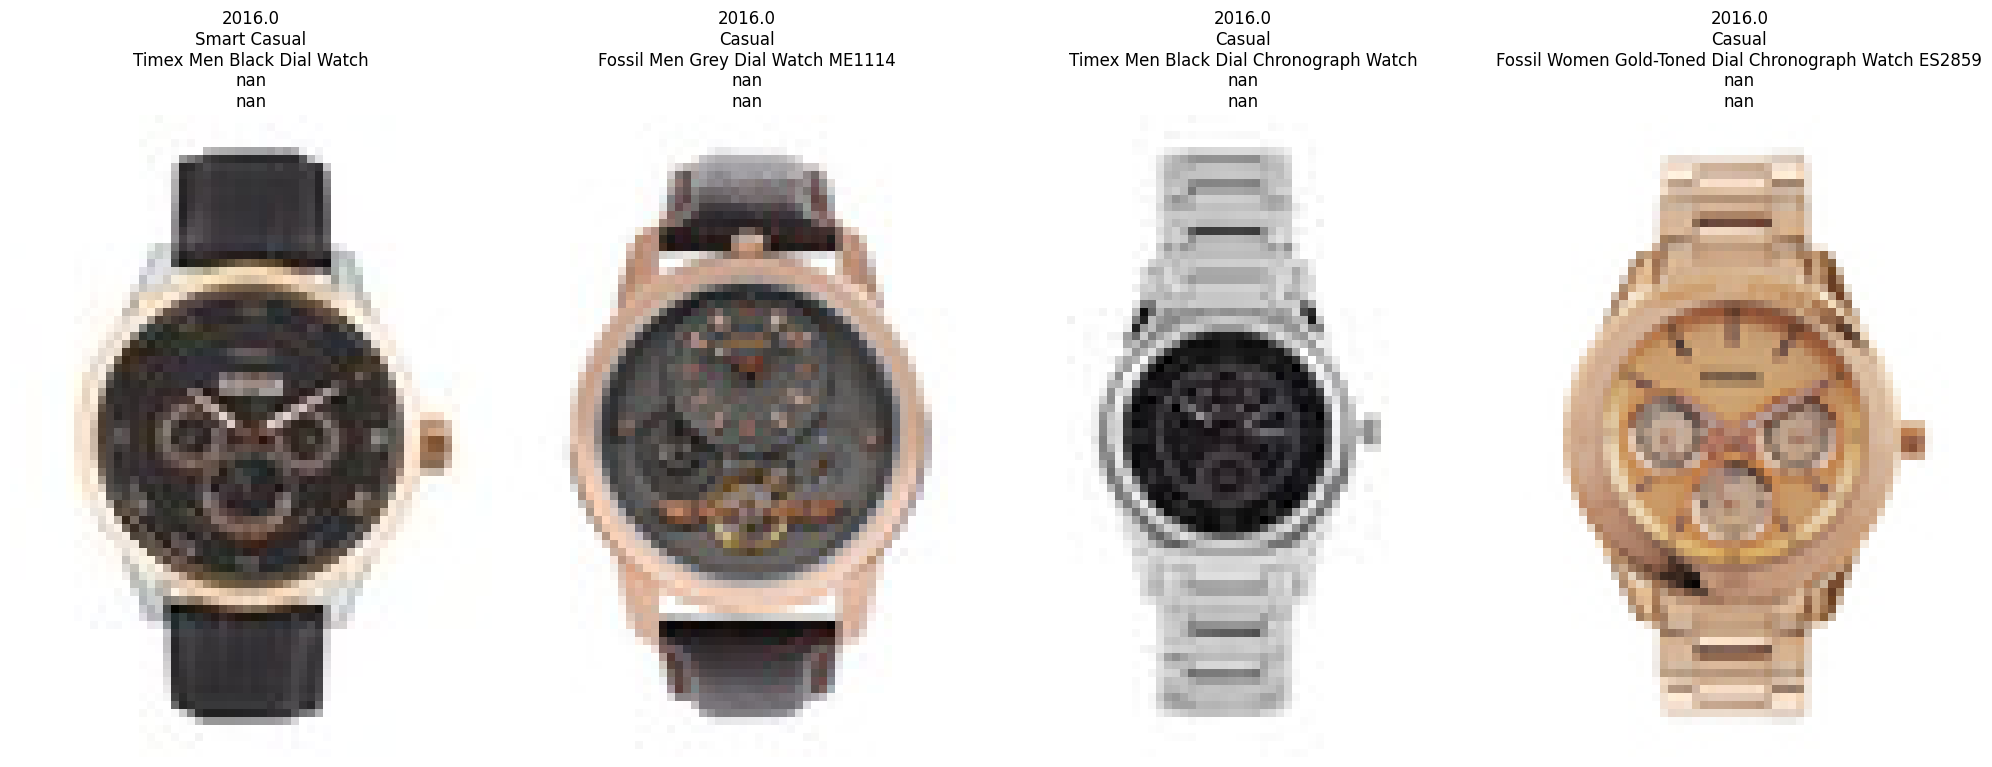

In [21]:
path_dict = {}
for path in Path('recomendacao/categories').rglob('*.jpg'):
  path_dict[path.name] = path

nns = t.get_nns_by_vector(test_vec, n=topK)
plt.figure(figsize=(20, 10))
for i in range(topK):
  x = file_index_to_file_name[nns[i]]
  x = path_dict[x+'.jpg']
  y = file_index_to_product_id[nns[i]]
  title = '\n'.join([str(j) for j in list(styles.loc[y].values[-5:])])
  plt.subplot(1, topK, i+1)
  plt.title(title)
  plt.imshow(mpimg.imread(x))
  plt.axis('off')
plt.tight_layout()